# Pruebas varias de NIR en Soja

In [1]:
#from data_loader import load_bolsa_m , load_bolsa
import os
import hdbscan
import pyclustering.cluster.optics as Op
import itertools
import numpy as np
import pandas as pd
import prettytable
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn import mixture

from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.metrics import silhouette_samples, silhouette_score, consensus_score
from sklearn.decomposition import RandomizedPCA
from sklearn.cross_validation import train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, estimate_bandwidth, MeanShift, KMeans, MiniBatchKMeans, SpectralClustering
from sklearn import metrics
from sklearn.neighbors import kneighbors_graph

from IPython.display import display, HTML

#%matplotlib nbagg
import warnings

# Utils

In [2]:
def load_bolsa(n_bolsa, fold="SojaData/"):
    """ Dada una carpeta 'fold', devuelve todos los datasets de una bolsa de datos 'Prueba' contenidos en ella
    concatenados """
    sdf = pd.DataFrame()
    for n in range(10):
        f_name = "Prueba Claudio Bolsa {0}-{1}.csv".format(n_bolsa, n)
        if  f_name in os.listdir(fold):
            df = pd.read_csv("SojaData/"+f_name, header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
            sdf = pd.concat([sdf,df])
    return sdf


def load_all(fold="SojaData"):
    """ Devuelve todos los archivos de la carpeta especificada como 'fold' concatenados en un solo DataFrame.
    La cantidad de columnas del Frame será igual al del file con la menor cantidad de features encontrado """
    columnas = []
    sdf = pd.DataFrame()
    for file in os.listdir(fold+"/"):
        df = pd.read_csv(fold+"/{0}".format(file), header=2, index_col=0, skip_blank_lines=True)
        if len(columnas) == 0:
            columnas = df.columns
        else:
            columnas = df.columns.difference(columnas)
        sdf = pd.concat([sdf,df])
    columnas = sdf.columns.difference(columnas)
    sdf.drop(axis=1, labels=columnas, inplace=True)
    return sdf


def plot_clusters(alg_name, data, labels, s_score):
    """ Plotea los datos recibidos
    Args:   alg_name = Nombre del algoritmo utilizado para plotear los datos
            data, labels = Conjunto de Datos y los clusters a los que pertenece cada uno
            s_score: Array con el Silohuete Score de cada observación
    IMPORTANTE: Los puntos del gráfico en ROJO son los valores tomados como 'Completamente
            mal clasificados'
    """
    print("Clusters encontrados: {}".format(len(np.unique(labels))))
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, alpha=0.25, s=80, linewidths=0, marker=".")
    
    errors = data[s_score < 0]
    print("Datos completamente mal clasificados: %d"%len(errors))
    semi_errors = data[s_score < .65]
    print("Datos con baja coherencia(<.65): %d"%len(semi_errors))
    plt.scatter(errors.T[0], errors.T[1], c="r", alpha=1, s=80, linewidths=0, marker=".")
    
    plt.title('Clusters con {}'.format(alg_name), fontsize=24)
    plt.show()

def plot_results(results):
    HDB_avg = results.iloc[:,5].mean()
    KM_avg = results.iloc[:,3].mean()
    MS_avg = results.iloc[:,2].mean()
    print("HDBScan Average: %f"%HDB_avg)
    print("KMeans Average: %f"%KM_avg)
    print("MShift Average: %f"%MS_avg)
    plt.figure("pepe")
    plt.xlabel("Bolsa")
    plt.ylabel("Silhouette Score")
    plt.plot(results.iloc[:,5], label="HDBScan")
    plt.plot(results.iloc[:,3], label="KMeans")
    plt.plot(results.iloc[:,2], label="MShift")
    plt.legend(loc=4)
    plt.show()

# Cargando Datos de de uso común

In [3]:
# carga de datos (Bolsas enteras concatenadas)
b_train = load_all("SojaData")
b_train.dropna(axis=1, inplace=True)

pca_train = RandomizedPCA(n_components=2, random_state=10).fit(b_train)
train, test = train_test_split(pca_train.transform(b_train), test_size=.35)

# Intento con MeanShift
### Demasiados datos, habria que utilizar otro método, pero para ir viendo un aproximado

bandwidth:0.35835690345321697; 
variance_ratio: [  9.99845292e-01   1.46336546e-04]

 silhouette_score:0.5372643005786802
 test size: 21218
Clusters encontrados: 3
Datos completamente mal clasificados: 1935
Datos con baja coherencia(<.65): 5598


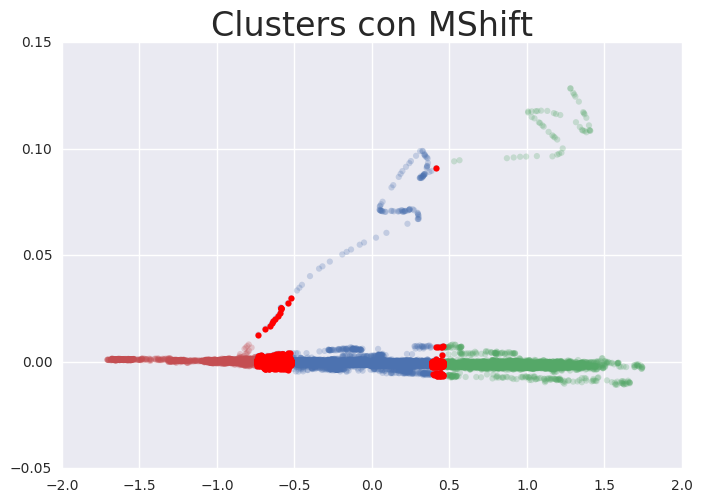

In [7]:
samples = train.shape[0]
# aumentando el parámetro 'quantile' a .3, la cantidad de clusters disminuye a 2, y
# si bien da un mejor score (casi nada, .58), todos los demás algoritmos arrojan mejores
# resultados con 3 clusters, por lo cual compare con el valor actual
b_width = estimate_bandwidth(train, quantile=0.25, n_samples=samples)
print("bandwidth:{0}; \nvariance_ratio: {1}".format(b_width, pca_train.explained_variance_ratio_))

modelo = MeanShift(bandwidth=b_width, bin_seeding=True, n_jobs=-1)
modelo.fit(train)

n_clusters = len( np.unique(modelo.labels_) )
centroides = modelo.cluster_centers_
#print("numero de clusters encontrados: {0}, centroides: \n{1}".format(n_clusters, centroides))

clusters = modelo.predict(test)
MS_ss = silhouette_score(test, clusters)
print("\n silhouette_score:{}\n test size: {}".format(MS_ss, test.shape[0]))

MS_ssv = silhouette_samples(test, clusters, "sqeuclidean")
plot_clusters("MShift", test, clusters, MS_ssv)

# intento con Kmeans
### Por ahora la mejor opción, tanto por aplicabilidad del algoritmo, como en resultados

silhouette avg = 0.6037403321991112
 test size: 21218
Clusters encontrados: 3
Datos completamente mal clasificados: 452
Datos con baja coherencia(<.65): 4489


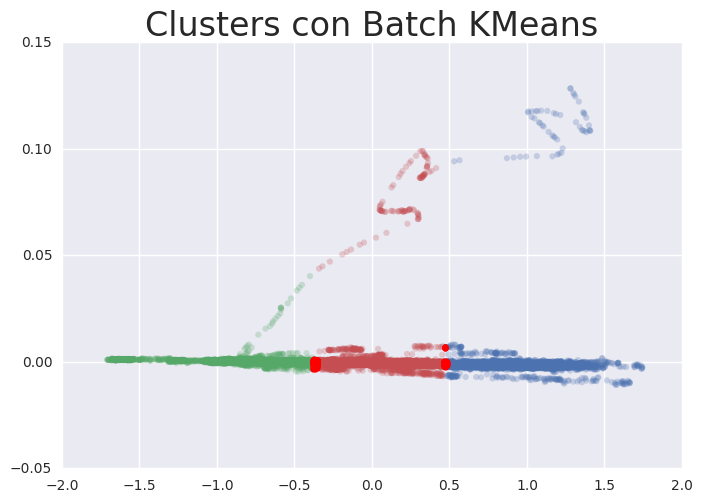

In [8]:
#cls = KMeans(n_clusters=3, init='k-means++', random_state=10)
warnings.filterwarnings("ignore", category=DeprecationWarning)
cls = MiniBatchKMeans(n_clusters=3, batch_size=40, n_init=10, max_no_improvement=5, reassignment_ratio=.1)

cls.fit(train)
clusters = cls.predict(test)
sa = silhouette_score(test, clusters)
ssv = silhouette_samples(test, clusters, "sqeuclidean") # sqeuclidean  cityblock  cosine  l1  l2
print("silhouette avg = {0}\n test size: {1}".format(sa,test.shape[0]))
plot_clusters("Batch KMeans", test, clusters, ssv)

# Intenando con GMM (Gaussian Mixture Models)
### Probando como Variante a B-KMeans

Silohuete Score: 0.605594957534575
test size : 21218
Clusters encontrados: 3
Datos completamente mal clasificados: 647
Datos con baja coherencia(<.65): 4314


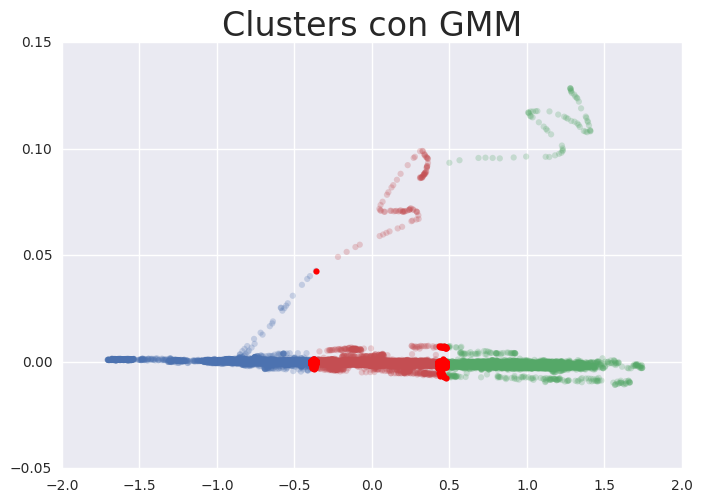

In [5]:
gmm_clf = mixture.GMM(n_components=3, covariance_type='tied')
gmm_clf.fit(train)

plt.figure("GMM Clustering")
Y = gmm_clf.predict(test)
gmm_sa = silhouette_score(test, Y)
gmm_ssv = silhouette_samples(test, Y, "sqeuclidean")
print("Silohuete Score: {}".format(gmm_sa))
print("test size : {}".format(test.shape[0]))
plot_clusters("GMM", test, Y, gmm_ssv)

# Intento con HDBSCAN
### implementación fuera de sci-kit, no es muy viable, probando solo con el slide de Test (35%)

Silohuete Score: 0.485428
Clusters encontrados: 3
Datos completamente mal clasificados: 2770
Datos con baja coherencia(<.65): 11670


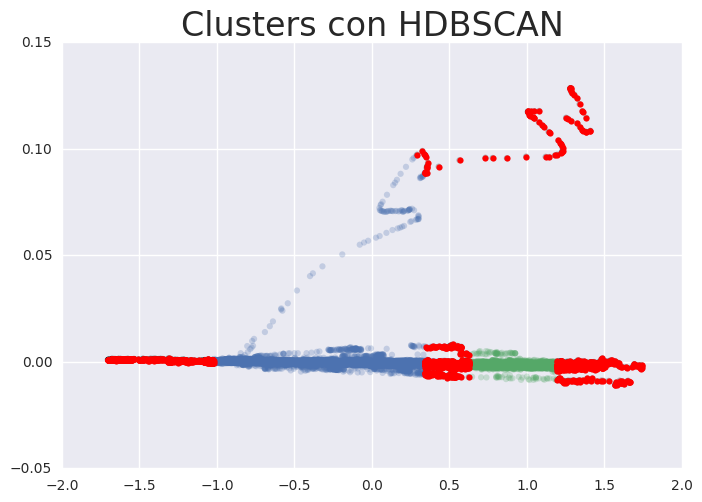

In [49]:
hdb_cls = hdbscan.HDBSCAN(min_cluster_size=2000, min_samples=1000)
labels = hdb_cls.fit_predict(test)
hdb_ss = silhouette_score(test, labels)
print("Silohuete Score: %f"%hdb_ss)
hdb_ssv = silhouette_samples(test, labels)
plot_clusters("HDBSCAN", test, labels, hdb_ssv)

# Intentando con AgglomerativeClustering

In [11]:
graph = kneighbors_graph(train, 3, include_self=False, mode="connectivity")
cls = AgglomerativeClustering(linkage='complete', n_clusters=3, connectivity=graph)  # 'ward', 'average', 'complete'
cls.fit_predict(train)
#label = cls.predict(test)

ss = silhouette_score(train, cls.labels_)
ssv = silhouette_samples(test, cls.labels_, "sqeuclidean")
print("Silhouette Score: {}".format(ss))

plot_clusters("Aglomerativo", train, cls.labels_, ssv)
#plt.figure(figsize=(6, 4))
#for i in range(train_2.shape[0]):
#    plt.text(train_2[i, 0], train_2[i, 1], icon, color=plt.cm.spectral(labels[i] / 10.), fontdict={'weight': 'normal', 'size': 9})

/usr/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:443: UserWarning: the number of connected components of the connectivity matrix is 202 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


MemoryError: 

# Comparacion de Clusterings
### MeanShift, KMeans y HDBScan

,Bolsa,Clusters,Sil_MShift,Sil_KMeans,HDBScan(Cls),Sil_HDBScan
0,0.0,3.0,0.836514,0.838874,3.0,0.715871
1,1.0,3.0,0.832707,0.833552,3.0,0.688578
2,2.0,3.0,0.825361,0.830025,3.0,0.711791
3,3.0,3.0,0.835539,0.834984,3.0,0.692109
4,4.0,3.0,0.819908,0.821755,3.0,0.738716
5,5.0,3.0,0.827633,0.828044,3.0,0.705388
6,6.0,3.0,0.826023,0.829797,3.0,0.719987
7,7.0,3.0,0.832702,0.832874,3.0,0.714935
8,8.0,3.0,0.832234,0.837186,3.0,0.706607
9,9.0,3.0,0.825894,0.827209,3.0,0.722115


HDBScan Average: 0.714388
KMeans Average: 0.830775
MShift Average: 0.829034


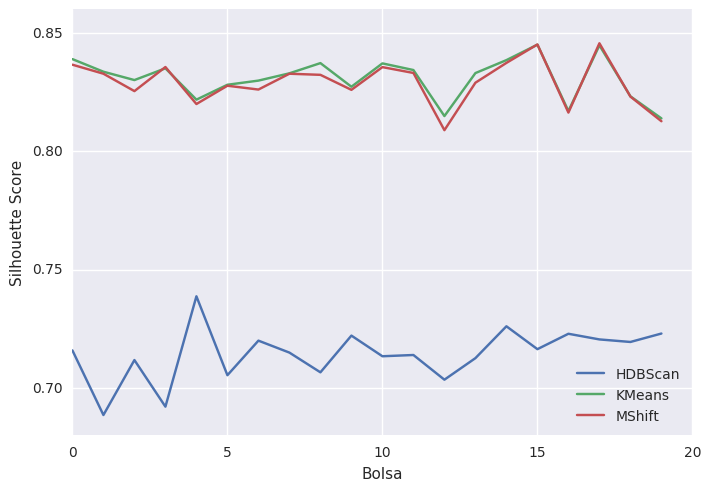

In [10]:
results = pd.DataFrame(columns=["Bolsa", "Clusters", "Sil_MShift", "Sil_KMeans", "HDBScan(Cls)", "Sil_HDBScan"])

for i in range(20):
    df = load_bolsa(1)
    if df.empty:
        continue
    
    df.dropna(axis=1, inplace=True)
    pca_train = RandomizedPCA(n_components=2, random_state=10).fit(df)
    df_t = pca_train.transform(df)
    b_train, test = train_test_split(df_t, test_size=.2)
        
    samples = b_train.shape[0]
    b_width = estimate_bandwidth(b_train, quantile=0.25, n_samples=samples)

    modelo = MeanShift(bandwidth=b_width, bin_seeding=True)
    modelo.fit(b_train)
    centroides = modelo.cluster_centers_

    labels_unique = np.unique(modelo.labels_)
    num_clusters = len(labels_unique)
    clusters = modelo.predict(test)
    ss_MShift = silhouette_score(test, clusters, "sqeuclidean")


    #cls = KMeans(init='k-means++', n_clusters=num_clusters, random_state=10)
    cls = KMeans(init='k-means++', n_clusters=3, random_state=10)
    cls.fit(b_train)
    clusters = cls.predict(test)
    ss_Kmeans = silhouette_score(test, clusters, "sqeuclidean")

    
    hdb_cls = hdbscan.HDBSCAN(min_cluster_size=700, min_samples=150)
    hdb_labels = hdb_cls.fit_predict(b_train)
    hdb_ss = silhouette_score(b_train, hdb_labels, "sqeuclidean")
    hdb_ssv = silhouette_samples(b_train, hdb_labels)

    results.loc[i] = [i, num_clusters, ss_MShift, ss_Kmeans, len(np.unique(hdb_labels)), hdb_ss]

display(results)
plot_results(results)

# Clustering bolsa por bolsa

In [13]:
# Solo se prueba con KMeans y MShift porque la cantidad de elementos por dataset es demasiado baja para otros algoritmos
for j in range(30):
    bolsa_x = load_bolsalsa_m(j)
    if bolsa_x.empty:
        continue
    
    print("Bolsa %d"%j)

    i = -1
    results_bolsa =pd.DataFrame(columns=["Clusters", "Sil_MShift", "Sil_KMeans"])
    for k, f in bolsa_x.iteritems():
        i = i+1
        f.dropna(axis=1, how="any",inplace=True)

    # Division en grupos de Entrenamiento-Testeo, y Análisis de PCA
        pca_train = RandomizedPCA(n_components=2, random_state=10).fit(f)
        f_t = pca_train.transform(f)
        train, test = train_test_split(f_t, test_size=.3)

    # Clusterización por MeanShift
        samples = train.shape[0]
        b_width = estimate_bandwidth(train, quantile=0.3, n_samples=samples)
        modelo = MeanShift(bandwidth=b_width, bin_seeding=True)
        modelo.fit(train)

        labels_unique = np.unique(modelo.labels_)
        num_clusters = len(labels_unique)
        clusters = modelo.predict(test)
        ss_MShift = silhouette_score(test, clusters)

    # Clusterización por KMeans, con la cantidad de clusters hallada por MShift
        cls = KMeans(init='k-means++', n_clusters=num_clusters, random_state=10)
        cls.fit(train)
        clusters = cls.predict(test)
        ss_Kmeans = silhouette_score(test, clusters)
#        ssv = silhouette_samples(test, clusters, "sqeuclidean")
        results_bolsa.loc[i] = [num_clusters, ss_MShift, ss_Kmeans]

    print("\t Avg KMeans: {0}\n\t Avg MShift: {1}".format(round(results_bolsa.iloc[:,2].mean(), 4), round(results_bolsa.iloc[:,1].mean(), 4)))    
    display(results_bolsa)


Bolsa 1
	 Avg KMeans: 0.8106
	 Avg MShift: 0.8106


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.828845,0.828845
1,3.0,0.802406,0.802406
2,3.0,0.807211,0.807211
3,3.0,0.811443,0.811443
4,3.0,0.828524,0.828524
5,3.0,0.805986,0.805986
6,3.0,0.790749,0.790749
7,3.0,0.799238,0.799238
8,3.0,0.797325,0.797325
9,3.0,0.834138,0.834138


Bolsa 2
	 Avg KMeans: 0.809
	 Avg MShift: 0.809


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.820815,0.820815
1,3.0,0.818103,0.818103
2,3.0,0.819313,0.819313
3,3.0,0.789886,0.789886
4,3.0,0.758955,0.758955
5,3.0,0.838568,0.838568
6,3.0,0.829662,0.829662
7,3.0,0.796596,0.796596


Bolsa 3
	 Avg KMeans: 0.7971
	 Avg MShift: 0.797


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.812539,0.812539
1,3.0,0.819539,0.819539
2,3.0,0.816779,0.816779
3,3.0,0.773950,0.774491
4,3.0,0.819913,0.819913
5,3.0,0.778376,0.778376
6,3.0,0.788772,0.788772
7,3.0,0.766040,0.766040


Bolsa 4
	 Avg KMeans: 0.7839
	 Avg MShift: 0.7839


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.796596,0.796596
1,3.0,0.778837,0.778837
2,3.0,0.761190,0.761190
3,3.0,0.819140,0.818924
4,3.0,0.779973,0.779973
5,3.0,0.780649,0.780649
6,3.0,0.770861,0.770861


Bolsa 5
	 Avg KMeans: 0.8001
	 Avg MShift: 0.7972


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.823243,0.823243
1,3.0,0.815651,0.815651
2,3.0,0.809918,0.808421
3,3.0,0.809784,0.809784
4,3.0,0.814931,0.814931
5,3.0,0.754593,0.754593
6,3.0,0.772908,0.772908
7,3.0,0.795043,0.795043
8,3.0,0.839859,0.839859
9,4.0,0.736036,0.767046


Bolsa 6
	 Avg KMeans: 0.8031
	 Avg MShift: 0.8032


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.807533,0.807533
1,3.0,0.765149,0.765149
2,3.0,0.816400,0.816400
3,3.0,0.799310,0.799230
4,3.0,0.827378,0.827378
5,3.0,0.818156,0.818156
6,3.0,0.793430,0.793430
7,3.0,0.780750,0.780750
8,3.0,0.807052,0.807052
9,3.0,0.816365,0.816365


Bolsa 7
	 Avg KMeans: 0.7773
	 Avg MShift: 0.7773


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.825472,0.825472
1,3.0,0.790457,0.790457
2,3.0,0.779503,0.779503
3,3.0,0.774370,0.774370
4,3.0,0.793622,0.793622
5,2.0,0.728439,0.728439
6,3.0,0.767859,0.767859
7,3.0,0.792663,0.792663
8,3.0,0.782007,0.782007
9,3.0,0.738225,0.738225


Bolsa 8
	 Avg KMeans: 0.8049
	 Avg MShift: 0.8047


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.835276,0.835276
1,3.0,0.838613,0.838613
2,3.0,0.807012,0.808351
3,3.0,0.766828,0.766828
4,3.0,0.827985,0.827985
5,3.0,0.809555,0.809555
6,3.0,0.791994,0.791994
7,3.0,0.769476,0.769476
8,3.0,0.813834,0.813834
9,3.0,0.786646,0.786646


Bolsa 9
	 Avg KMeans: 0.8078
	 Avg MShift: 0.8081


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.820807,0.820807
1,3.0,0.831149,0.831149
2,3.0,0.749762,0.749762
3,3.0,0.805354,0.805354
4,3.0,0.834264,0.834264
5,3.0,0.810410,0.810410
6,3.0,0.791768,0.791768
7,3.0,0.836570,0.836570
8,3.0,0.821118,0.817917
9,3.0,0.779697,0.779697


Bolsa 10
	 Avg KMeans: 0.7977
	 Avg MShift: 0.7979


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.789453,0.789453
1,3.0,0.813975,0.813975
2,3.0,0.788429,0.788429
3,3.0,0.807115,0.807115
4,3.0,0.808876,0.808876
5,3.0,0.783206,0.783206
6,3.0,0.780849,0.780849
7,3.0,0.818344,0.818344
8,3.0,0.788563,0.787063
9,3.0,0.800184,0.800184


Bolsa 11
	 Avg KMeans: 0.8022
	 Avg MShift: 0.8022


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.768700,0.768700
1,3.0,0.823187,0.823187
2,3.0,0.813630,0.813732
3,3.0,0.790045,0.790045
4,3.0,0.807694,0.807694
5,3.0,0.776102,0.776102
6,3.0,0.803505,0.803505
7,3.0,0.807011,0.807011
8,3.0,0.812076,0.812076
9,3.0,0.819939,0.819939


Bolsa 12
	 Avg KMeans: 0.8053
	 Avg MShift: 0.8054


,Clusters,Sil_MShift,Sil_KMeans
0,3.0,0.802678,0.802678
1,3.0,0.808849,0.808849
2,3.0,0.778702,0.778702
3,3.0,0.789393,0.789393
4,3.0,0.808533,0.808533
5,3.0,0.789662,0.789662
6,3.0,0.832162,0.832162
7,3.0,0.805055,0.805055
8,3.0,0.831472,0.831472
9,3.0,0.807918,0.806193


# Clasificación por Bolsa completa

In [27]:
files = os.listdir("SojaData/*")
for i,(n, f) in enumerate(range(20), zip()):
    f = load_bolsa(i)
    if f.empty:
        continue
        
#     f.drop(labels=["Range:","Time:"], axis=0, inplace=True)
    f.dropna(axis=1, how="any",inplace=True)

    # Division en grupos de Entrenamiento-Testeo, y Análisis de PCA
    pca_train = RandomizedPCA(n_components=2, random_state=10).fit(f)
    f_t = pca_train.transform(f)
    train, test = train_test_split(f_t, test_size=.3)
    cls = KMeans(init='k-means++', n_clusters=3, random_state=10)
    labels = cls.fit_predict(f_t)
    f["clase"] = labels
    print("Clasificación Bolsa {}".format(i))
    display(f.iloc[:,-3:])

Clasificación Bolsa 1


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.691465,0.689978,0
1202.0,0.691460,0.690312,0
1204.0,0.691551,0.690732,0
1206.0,0.691643,0.691136,0
1208.0,0.691503,0.691148,0
1210.0,0.691088,0.690633,0
1212.0,0.689918,0.689470,0
1214.0,0.688144,0.687757,2
1216.0,0.685819,0.685574,2


Clasificación Bolsa 2


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.643177,0.642141,1
1202.0,0.643491,0.642442,1
1204.0,0.643648,0.642866,1
1206.0,0.643556,0.643194,1
1208.0,0.642901,0.643178,1
1210.0,0.641915,0.642739,1
1212.0,0.640664,0.641690,1
1214.0,0.638937,0.640056,1
1216.0,0.636903,0.637689,1


Clasificación Bolsa 3


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.643403,0.645452,0
1202.0,0.643761,0.645515,0
1204.0,0.644205,0.645550,0
1206.0,0.644450,0.645406,0
1208.0,0.644479,0.645276,0
1210.0,0.644030,0.644729,0
1212.0,0.643113,0.643614,0
1214.0,0.641824,0.641987,0
1216.0,0.639868,0.639723,0


Clasificación Bolsa 4


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.568098,0.567609,0
1202.0,0.568278,0.567938,0
1204.0,0.568499,0.568223,0
1206.0,0.568659,0.568471,0
1208.0,0.568611,0.568468,0
1210.0,0.568206,0.568114,0
1212.0,0.567504,0.567371,0
1214.0,0.566474,0.566223,0
1216.0,0.565103,0.564740,0


Clasificación Bolsa 5


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.617183,0.617029,0
1202.0,0.617235,0.617321,0
1204.0,0.617392,0.617619,0
1206.0,0.617619,0.617749,0
1208.0,0.617764,0.617607,0
1210.0,0.617641,0.617066,0
1212.0,0.617296,0.616429,0
1214.0,0.616623,0.615612,0
1216.0,0.615458,0.614397,0


Clasificación Bolsa 6


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.636893,0.636909,0
1202.0,0.637142,0.637070,0
1204.0,0.637330,0.637385,0
1206.0,0.637423,0.637724,0
1208.0,0.637287,0.637755,0
1210.0,0.636710,0.637376,0
1212.0,0.635647,0.636342,0
1214.0,0.634035,0.634711,0
1216.0,0.631767,0.632330,0


Clasificación Bolsa 7


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.646390,0.647407,0
1202.0,0.646738,0.647386,0
1204.0,0.647163,0.647498,0
1206.0,0.647422,0.647612,0
1208.0,0.647543,0.647768,0
1210.0,0.647508,0.647691,0
1212.0,0.647218,0.647357,0
1214.0,0.646762,0.646851,0
1216.0,0.646013,0.646307,0


Clasificación Bolsa 8


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.633805,0.632947,2
1202.0,0.633811,0.632986,2
1204.0,0.634025,0.633127,2
1206.0,0.634195,0.633277,2
1208.0,0.634096,0.633376,2
1210.0,0.633779,0.633113,2
1212.0,0.633028,0.632440,2
1214.0,0.631704,0.631321,2
1216.0,0.629858,0.629615,2


Clasificación Bolsa 9


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.709363,0.709185,0
1202.0,0.709960,0.709444,0
1204.0,0.710359,0.709626,0
1206.0,0.710444,0.709697,0
1208.0,0.710163,0.709459,0
1210.0,0.709310,0.708554,0
1212.0,0.707762,0.707083,0
1214.0,0.705665,0.704996,0
1216.0,0.702996,0.702405,1


Clasificación Bolsa 10


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.571858,0.572428,1
1202.0,0.572219,0.572753,1
1204.0,0.572599,0.573108,1
1206.0,0.572869,0.573307,1
1208.0,0.572994,0.573318,1
1210.0,0.572828,0.573122,1
1212.0,0.572385,0.572523,1
1214.0,0.571522,0.571603,1
1216.0,0.570399,0.570314,1


Clasificación Bolsa 11


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.606500,0.606398,2
1202.0,0.606799,0.606882,2
1204.0,0.607167,0.607523,2
1206.0,0.607539,0.608070,2
1208.0,0.607676,0.608309,2
1210.0,0.607476,0.608078,2
1212.0,0.606928,0.607463,2
1214.0,0.605905,0.606249,2
1216.0,0.604350,0.604729,2


Clasificación Bolsa 12


,Spectrum ( 8 ),Spectrum ( 9 ),clase
Range:,,,
1200.0,0.571969,0.572683,0
1202.0,0.572247,0.573123,0
1204.0,0.572491,0.573491,0
1206.0,0.572694,0.573660,0
1208.0,0.572655,0.573583,0
1210.0,0.572200,0.573109,0
1212.0,0.571311,0.572143,0
1214.0,0.570036,0.570766,0
1216.0,0.568486,0.569095,0


# Clasificación por Subsets dentro de cada Bolsas

/usr/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


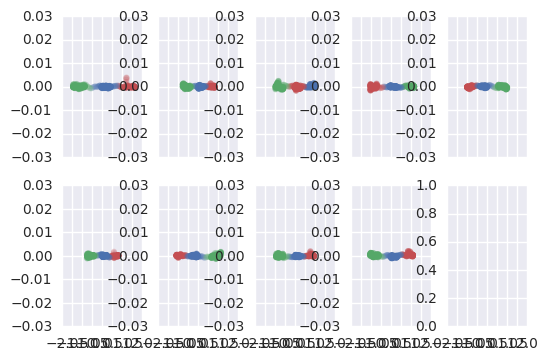

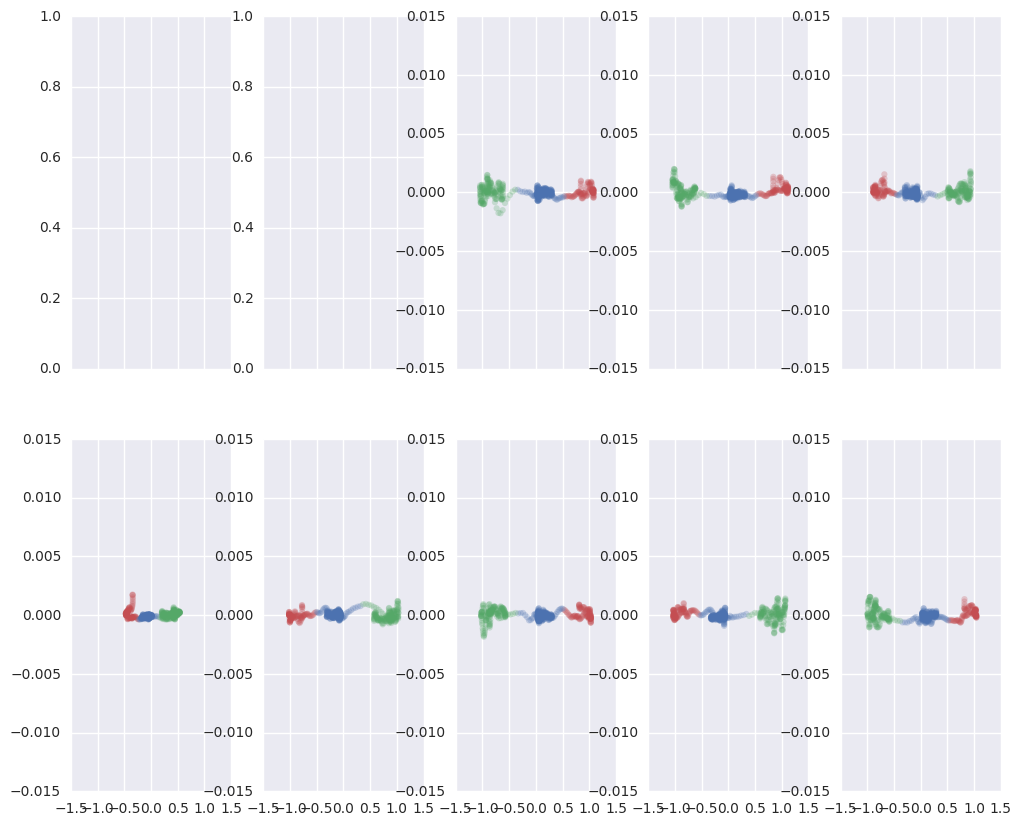

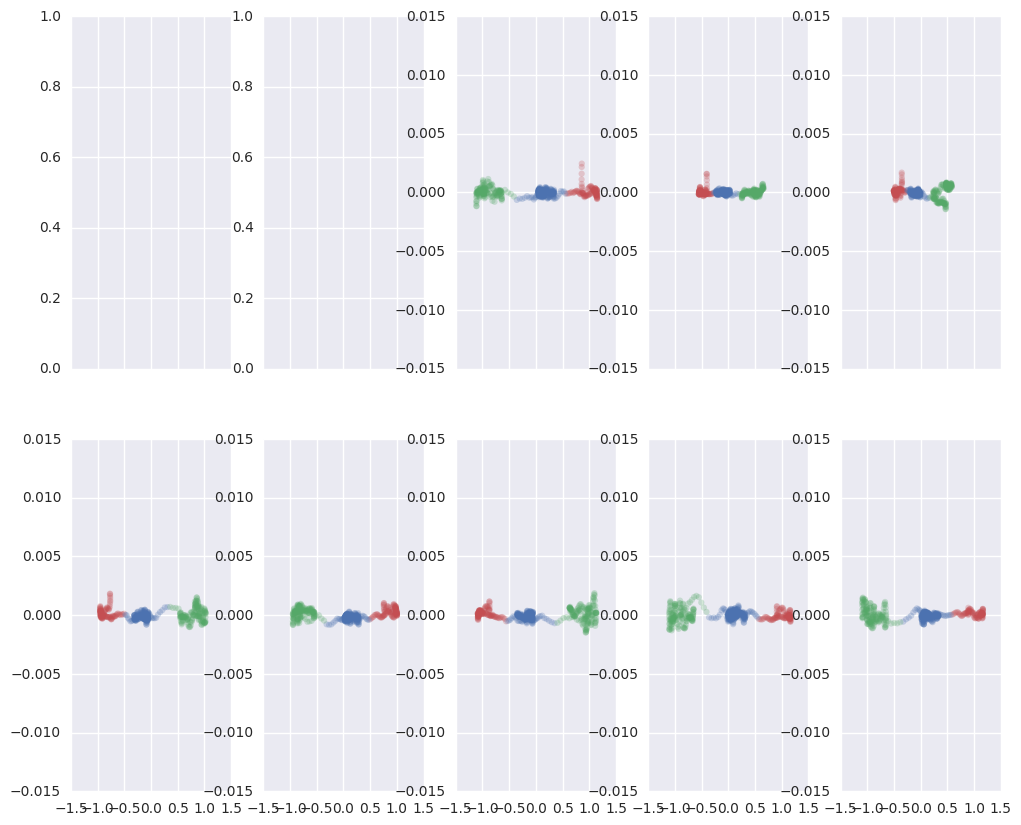

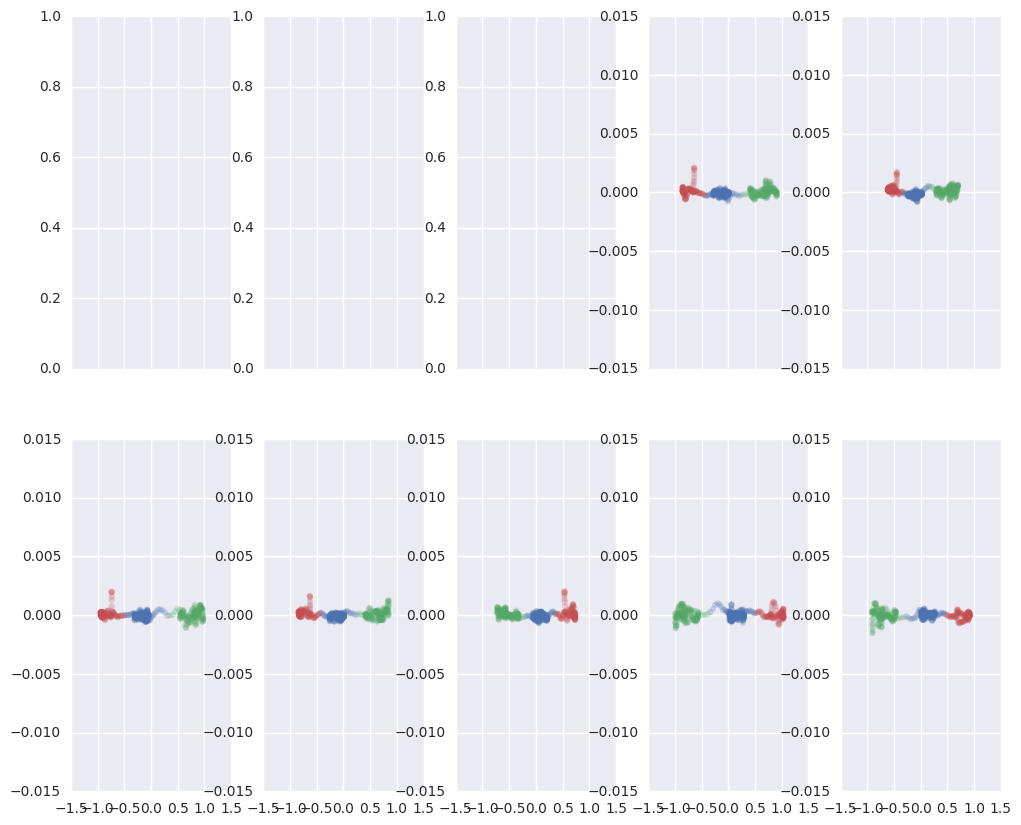

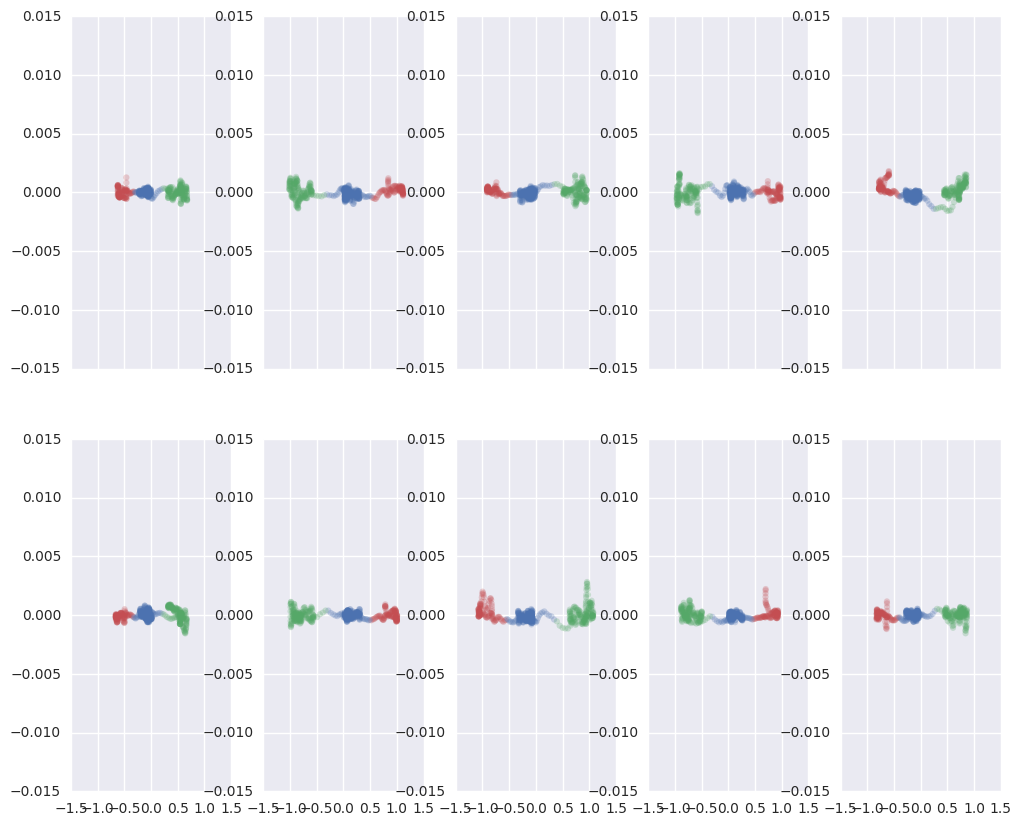

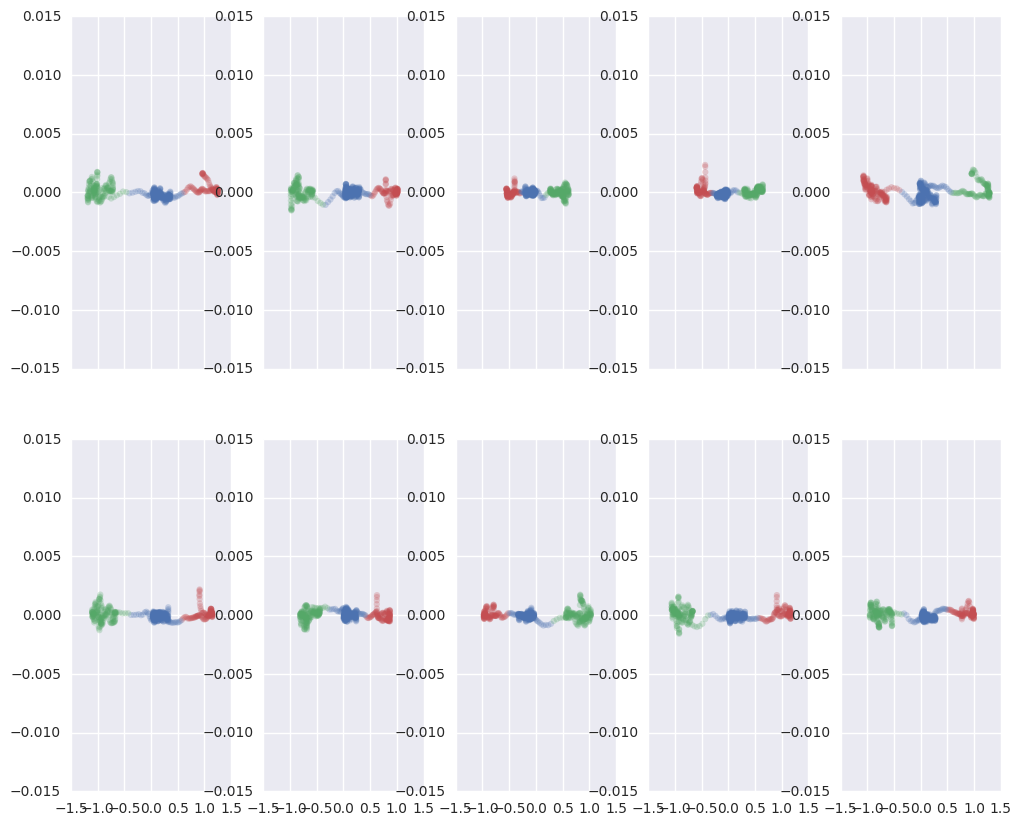

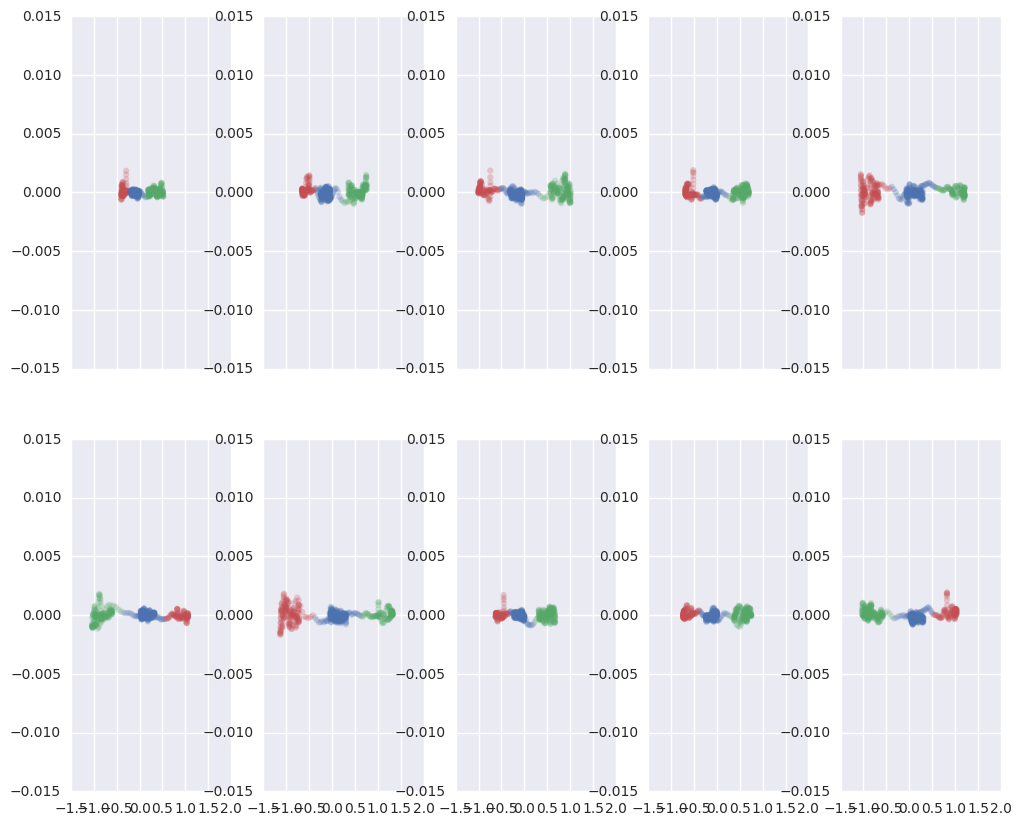

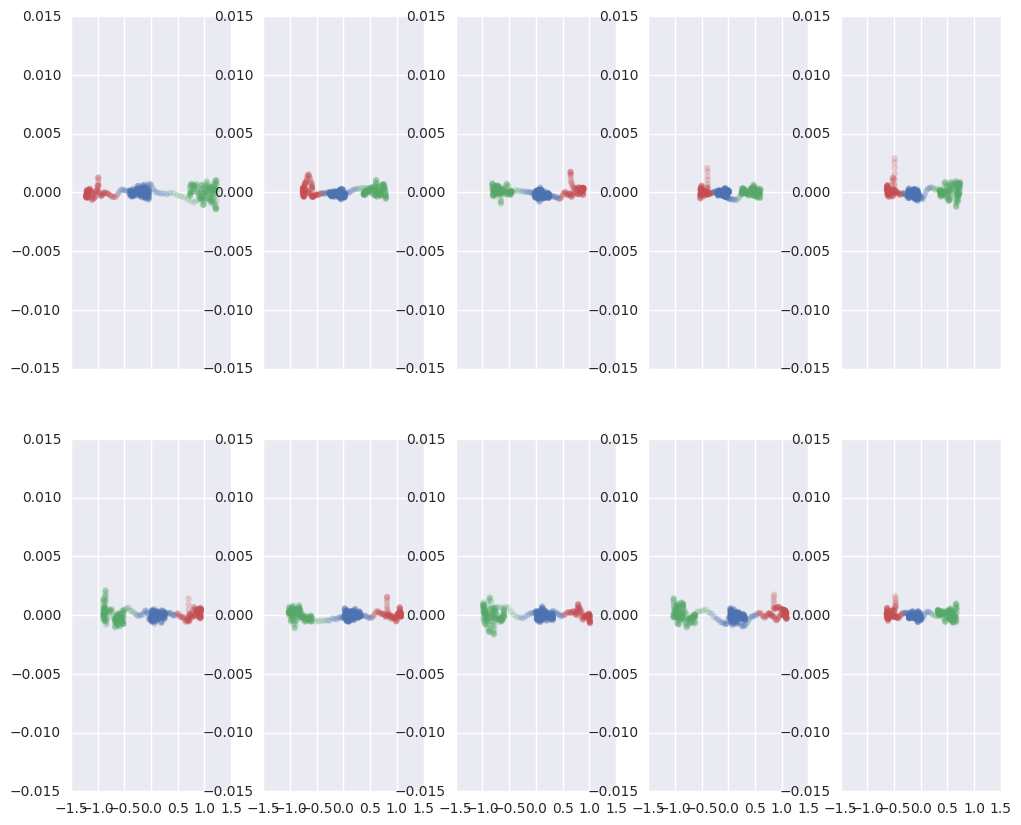

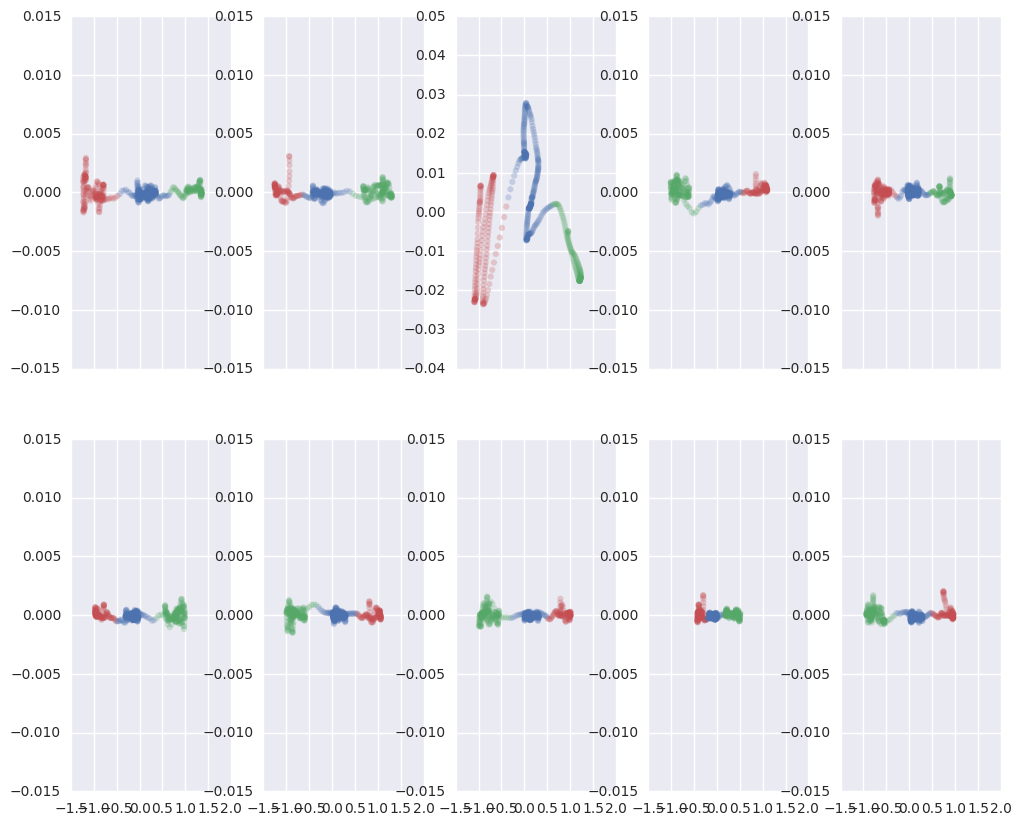

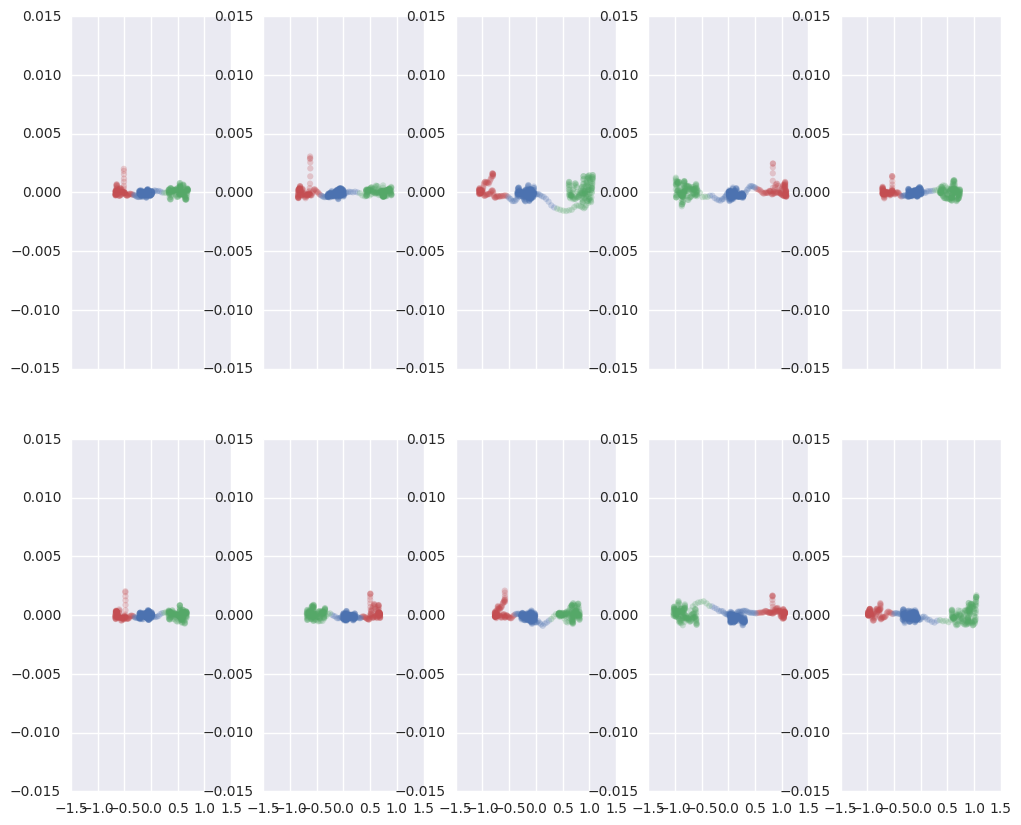

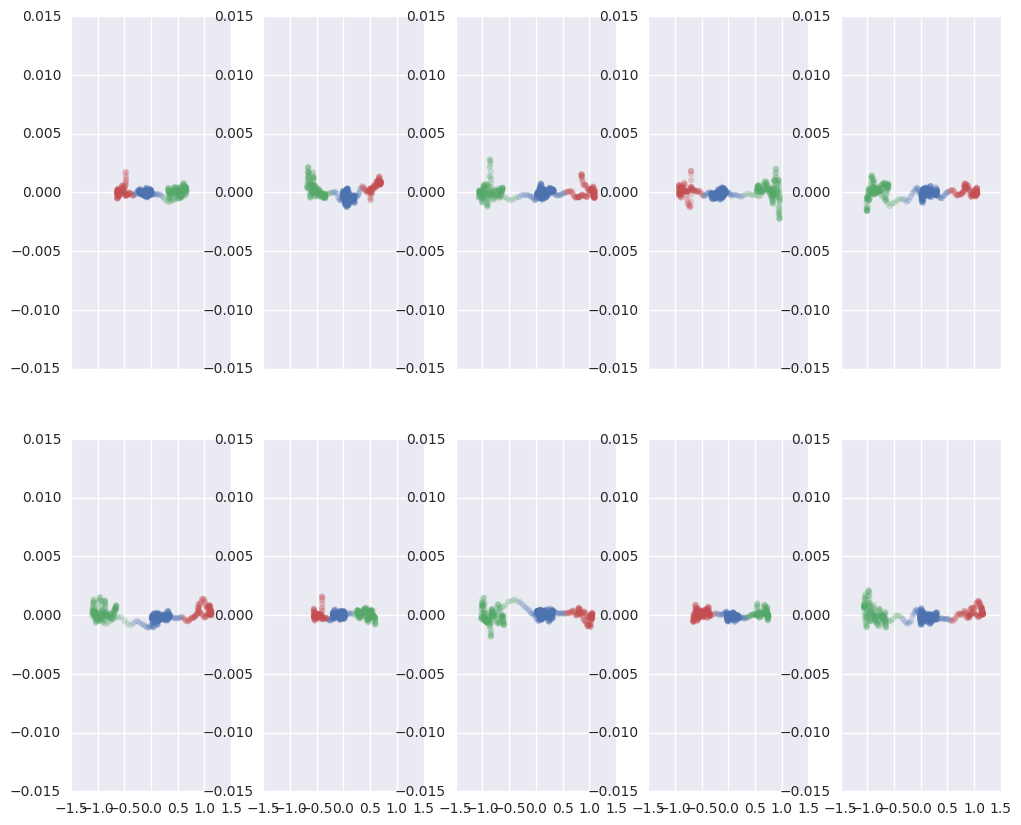

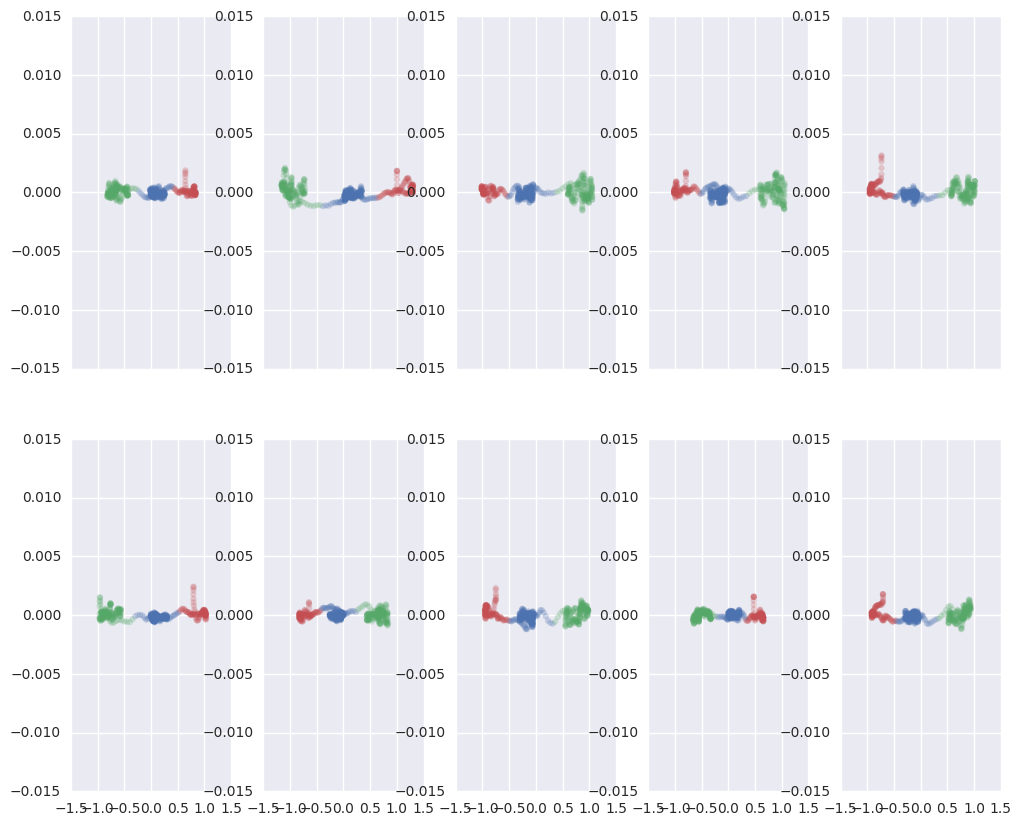

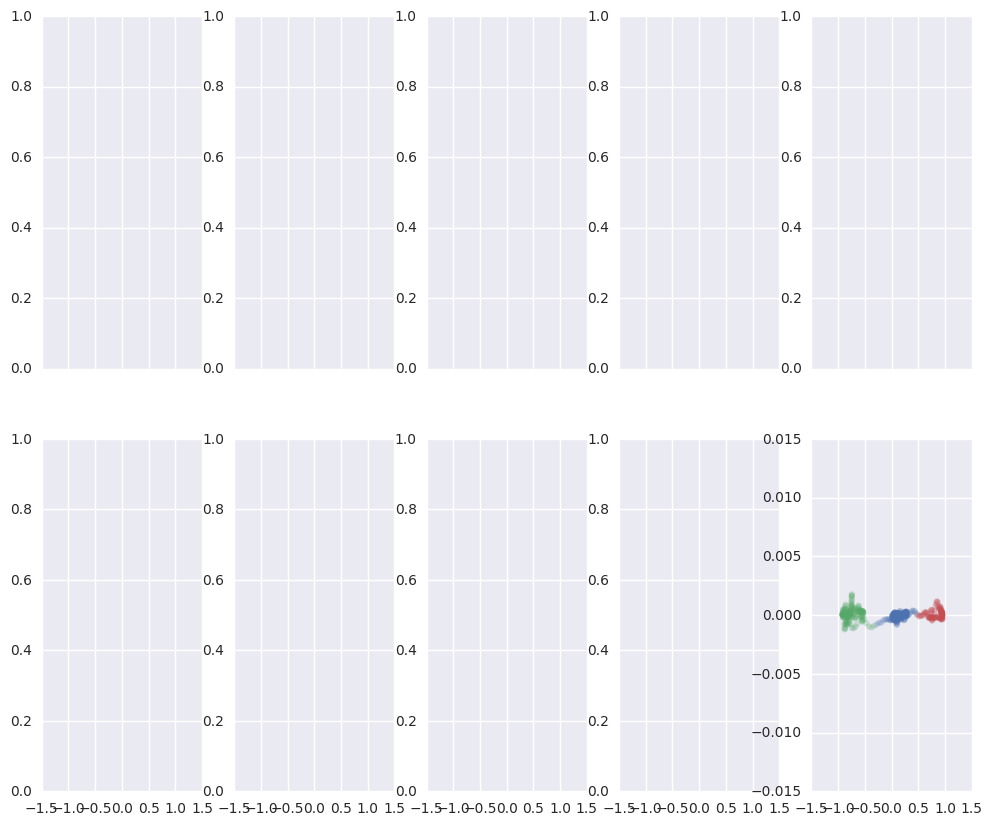

In [4]:
%matplotlib inline
dir_list = os.listdir("SojaData/")

palette = sns.color_palette('deep', 4)

fig, axarr = plt.subplots(2,5, sharex=True)
for i, j in itertools.product(range(25), range(13)):
    
    f_name = "Prueba Claudio Bolsa {}-{}.csv".format(i,j)
    if f_name in dir_list:
        f = pd.read_csv("SojaData/"+f_name, index_col=0, skip_blank_lines=True, skiprows=2)
#         f.drop(labels=["Range:","Time:"], axis=0, inplace=True)
        f.dropna(axis=1, how="any", inplace=True)

        pca_train = RandomizedPCA(n_components=2, random_state=10).fit(f)
        f_t = pca_train.transform(f)
        cls = KMeans(init='k-means++', n_clusters=3, random_state=10)
        labels = cls.fit_predict(f_t)
        f["clase"] = labels
#        print("Clasificación Bolsa {}-{}".format(i, j))
        
        #num_axis =  str(divmod(j,5)[0]+1) + str((j%5)+1)
#        axarr[i] = fig.add_subplot(int(num_axis), projection='2d')
        
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
        ind1 = divmod((j-1),5)[0]
        ind2 = ((j-1)%5)
#        print(ind1, ind2)
        axarr[ind1][ind2].scatter(f_t.T[0], f_t.T[1], c=colors, alpha=0.25, s=80, linewidths=0, marker=".")
#        print(j)
        if j==9:
            fig.show()
            fig, axarr = plt.subplots(2,5, sharex=True)
            fig.set_size_inches(h=10, w=12)
            #plt.show()

        #display(f.iloc[:,-3:])
